In [1]:
# Imports and Initial Setup
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import numpy as np
import copy
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import itertools

# Name to use for saving the model
model_path = 'DistilBERT Sentiment Model'

# Dataset (CSV) Column Names
sentence_column_name = "Sentences"
sentiment_column_name = "Final_Sent"

# To Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [2]:
# Data Splitting
# Load the dataset from CSV file
df = pd.read_csv('annotated_dataset.csv')
# Split data into 80% training+validation and 20% test
remaining, test = train_test_split(df, test_size=0.2, random_state=42)
# Split the remaining 80% into 70% training and 10% validation (0.125 of 80% = 10% overall)
train, val = train_test_split(remaining, test_size=0.125, random_state=42)

train, val, test

(                                              Sentences  \
 3394  Nate Silver's Bolton has Kamala Harris leading...   
 5118  This razor-thin margin demonstrates that Penns...   
 2269                            Trump leads by just 1%.   
 3190  How critical is winning the state of Michigan ...   
 4216  Am I saying Trump's going to win it by 21 poin...   
 ...                                                 ...   
 1282       Kamala Harris, I believe, fits all of those.   
 5520  This idea that she's going to magically do bet...   
 3963  It holds 15 electoral votes and it is very muc...   
 3086  Harris holds narrow leads in four critical bat...   
 2805  And so, I refuse a meeting with Donald Trump o...   
 
      Presidential_Candidate         State  Vote_1  Vote_2  Final_Sent  
 3394          Kamala Harris      Michigan       1       0           1  
 5118           Donald Trump  Pennsylvania       1       1           1  
 2269           Donald Trump      Michigan       1       0 

In [3]:
# Set up the model and compute class weights
def compute_class_weights(labels):
    """
    Calculate weights for each class to handle imbalanced data
    For example, if we have 100 positive but only 10 negative samples,
    negative samples will get higher weight to balance their importance
    """
    # Shift labels for model [-1, 0, 1] to [0, 1, 2]
    mapped_labels = labels + 1
    # Count how many samples we have of each class
    class_counts = np.bincount(mapped_labels)
    # Give higher weights to classes with fewer samples
    weights = 1. / class_counts
    # Normalize weights to sum to number of classes
    weights = weights * len(class_counts) / weights.sum()
    return torch.FloatTensor(weights)

# Calculate weights for each class from training data
class_weights = compute_class_weights(train[sentiment_column_name].values)
class_weights = class_weights.to(device)  # Move weights to GPU if available

class_weights

tensor([0.9941, 1.1636, 0.8422])

In [4]:
# Base DistilBERT model to use
model_name = 'distilbert-base-uncased'

# Create a custom DistilBERT model that can handle weighted loss
class DistilBertWithWeightedLoss(DistilBertForSequenceClassification):
    """
    Custom DistilBERT model that applies different weights to each class
    This helps handle imbalanced datasets better
    """
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights # Store class weights for loss calculation
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get model outputs without computing loss
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None # Set to None to prevent automatic loss calculation
        )
        
        # Calculate weighted loss if labels are provided (training phase)
        if labels is not None:
            # Create loss function with class weights
            loss_fct = CrossEntropyLoss(weight=self.class_weights)
            # Calculate loss using model predictions and true labels
            loss = loss_fct(
                outputs.logits.view(-1, self.num_labels),  # Reshape predictions
                labels.view(-1)                            # Reshape labels
            )
            outputs.loss = loss  # Add loss to outputs
        
        return outputs

# Initialize the tokenizer that will convert text to numbers
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [5]:
# Data Preparation Functions
def create_data_loader(data, tokenizer, batch_size):
    """
    Convert text data into a format DistilBERT can understand and create batches

    Args:
        data: DataFrame containing text and labels
        tokenizer: DistilBERT tokenizer to convert text to numbers
        batch_size: How many samples to process at once

    Returns:
        DataLoader that yields batches of processed data
    """
    # Convert text to DistilBERT input format with progress bar
    encodings = tokenizer(
        data[sentence_column_name].tolist(), # Convert sentences to list
        truncation=True, # Cut texts longer than max_length
        padding=True, # Pad texts shorter than max_length
        max_length=128, # Maximum sequence length
        return_tensors='pt', # Return PyTorch tensors
        verbose=True # Show progress
    )

    # Create dataset by combining inputs and labels
    dataset = torch.utils.data.TensorDataset(
        encodings['input_ids'], # Tokenized text
        encodings['attention_mask'], # Attention mask for padding
        torch.tensor(data[sentiment_column_name].tolist()) # Labels
    )

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Evaluation Function
def evaluate_model(model, data_loader, device):
    """
    Evaluate model performance using various metrics
    
    Args:
        model: The DistilBERT model to evaluate
        data_loader: DataLoader containing validation or test data
        device: CPU or GPU
    
    Returns:
        Dictionary containing various performance metrics
    """
    model.eval() # Set model to evaluation mode
    val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): # Don't compute gradients during evaluation
        for batch in tqdm(data_loader, desc="Evaluation"):
            # Move batch to GPU if available
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            adjusted_labels = labels + 1 # Shift labels for model

            # Get model predictions
            outputs = model(input_ids, attention_mask, labels=adjusted_labels)
            val_loss += outputs.loss.item()

            # Store predictions and true labels
            _, predicted = torch.max(outputs.logits, 1)
            all_preds.extend((predicted - 1).cpu().numpy())
            all_labels.extend((adjusted_labels - 1).cpu().numpy())

    # Calculate various performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return {
        'loss': val_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [7]:
# Training Function
def train_model(model, train_loader, val_loader, device, epochs, learning_rate):
    """
    Train the model and periodically evaluate its performance
    
    Args:
        model: The DistilBERT model to train
        train_loader: DataLoader with training data
        val_loader: DataLoader with validation data
        device: CPU or GPU
        epochs: Number of times to process all training data
        learning_rate: How quickly the model should learn
    
    Returns:
        Trained model and its best validation metrics
    """
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    best_metrics = None
    best_model = None
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    # Training loop
    for epoch in range(epochs):
        model.train() # Set model to training mode
        total_loss = 0
        
        # Process each batch
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")
        for batch in pbar:
            # Move batch to GPU if available
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            adjusted_labels = labels + 1 # Shift labels for model [-1, 0, 1] to [0, 1, 2]

            # Training step
            optimizer.zero_grad() # Clear previous gradients
            outputs = model(input_ids, attention_mask, labels=adjusted_labels) # Forward pass
            
            loss = outputs.loss
            total_loss += loss.item() # Accumulate loss

            # Update model weights
            loss.backward() # Backward pass
            optimizer.step() # Update weights

            # Update progress bar with current loss
            pbar.set_postfix(loss=loss.item())

        # Calculate average loss for this epoch
        avg_train_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Average training loss: {avg_train_loss:.4f}')        
        train_loss.append(avg_train_loss)
        
        val_metrics = evaluate_model(model, val_loader, device)
        print(f'Validation metrics: {val_metrics}')
        val_loss.append(val_metrics['loss'])
        val_accuracy.append(val_metrics['accuracy'])
        
        # Get and update model with lowest loss
        if best_metrics == None or best_metrics['loss'] > val_metrics['loss']:
            best_metrics = val_metrics
            best_model = copy.deepcopy(model)
    
    return best_model, best_metrics, {'train_loss': train_loss, 'val_loss': val_loss, 'val_accuracy': val_accuracy}

In [8]:
# Define different values to try for each parameter
param_grid = {
    'learning_rate': [2e-5], #, 5e-5 DistilBERT works well with similar learning rates as BERT
    'batch_size': [32], # Same batch size as BERT works well
    'epochs': [2] # DistilBERT might converge faster due to its smaller size
}

# Hyperparameter Tuning Function
def hyperparameter_tuning(train_data, val_data, device, class_weights):
    """
    Try different combinations of hyperparameters to find the best ones
    
    Args:
        train_data: Training data DataFrame
        val_data: Validation data DataFrame
        device: CPU or GPU
        class_weights: Weights for each class
    
    Returns:
        Best parameters and their corresponding metrics
    """    
    # Create all possible combinations of parameters
    param_combinations = [
        dict(zip(param_grid.keys(), v)) 
        for v in itertools.product(*param_grid.values())
    ]

    best_model = None
    best_metrics = None
    best_params = None
    best_metric_seq = {}

    # Try each combination of parameters
    for params in param_combinations:
        print(f"\nTrying parameters: {params}")

        # Create data loaders with current batch size
        train_loader = create_data_loader(train_data, tokenizer, params['batch_size'])
        val_loader = create_data_loader(val_data, tokenizer, params['batch_size'])

        # Initialize the custom DistilBERT model
        model = DistilBertWithWeightedLoss.from_pretrained(
            model_name,
            # Configure DistilBERT for classification
            config=DistilBertForSequenceClassification.from_pretrained(
                model_name,
                num_labels=3,
                output_attentions=False, # Don't output attention weights
                output_hidden_states=False, # Don't output hidden states
            ).config,
            class_weights=class_weights
        )
        # Move model to GPU if available
        model.to(device)

        # Train model with current parameters
        model, val_metrics, metric_seq = train_model(
            model, 
            train_loader, 
            val_loader,
            device,
            params['epochs'],
            params['learning_rate']
        )

        # Get and update model with lowest loss
        if best_metrics == None or best_metrics['loss'] > val_metrics['loss']:
            best_model = copy.deepcopy(model)
            best_params = params
            best_metrics = val_metrics
            best_metric_seq = metric_seq
    
    return best_model, best_params, best_metrics, best_metric_seq

In [9]:
# Run Hyperparameter Tuning
best_model, best_params, best_metrics, best_metric_seq = hyperparameter_tuning(train, val, device, class_weights)
print(f"\nBest parameters: {best_params}")
print(f"Best validation metrics: {best_metrics}")

# Save the best model
best_model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

best_model, {key: sum(val) / len(val) for key, val in best_metric_seq.items()}


Trying parameters: {'learning_rate': 2e-05, 'batch_size': 32, 'epochs': 10}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertWithWeightedLoss were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI Laptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=Tru

Epoch 1/10, Average training loss: 0.9110


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.07it/s]


Validation metrics: {'loss': 0.8059898581769731, 'accuracy': 0.6295652173913043, 'precision': 0.6532618073438919, 'recall': 0.6295652173913043, 'f1': 0.6292639464129022}


Epoch 2/10 Training: 100%|███████████████████████████████████████████████| 126/126 [09:29<00:00,  4.52s/it, loss=0.597]


Epoch 2/10, Average training loss: 0.6377


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.10it/s]


Validation metrics: {'loss': 0.7725992235872481, 'accuracy': 0.6591304347826087, 'precision': 0.6534196939029154, 'recall': 0.6591304347826087, 'f1': 0.6543936967454482}


Epoch 3/10 Training: 100%|███████████████████████████████████████████████| 126/126 [09:34<00:00,  4.56s/it, loss=0.435]


Epoch 3/10, Average training loss: 0.4437


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.07it/s]


Validation metrics: {'loss': 0.938737584484948, 'accuracy': 0.6556521739130434, 'precision': 0.6467543539154792, 'recall': 0.6556521739130434, 'f1': 0.6411277555479747}


Epoch 4/10 Training: 100%|███████████████████████████████████████████████| 126/126 [09:32<00:00,  4.55s/it, loss=0.903]


Epoch 4/10, Average training loss: 0.3003


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.09it/s]


Validation metrics: {'loss': 0.9603926108943092, 'accuracy': 0.6939130434782609, 'precision': 0.6894443302628874, 'recall': 0.6939130434782609, 'f1': 0.6907011395903263}


Epoch 5/10 Training: 100%|███████████████████████████████████████████████| 126/126 [09:56<00:00,  4.73s/it, loss=0.291]


Epoch 5/10, Average training loss: 0.1760


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.09it/s]


Validation metrics: {'loss': 1.152358306778802, 'accuracy': 0.6730434782608695, 'precision': 0.6686497801823427, 'recall': 0.6730434782608695, 'f1': 0.6687461634103972}


Epoch 6/10 Training: 100%|███████████████████████████████████████████████| 126/126 [09:40<00:00,  4.60s/it, loss=0.175]


Epoch 6/10, Average training loss: 0.1160


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.07it/s]


Validation metrics: {'loss': 1.213312092754576, 'accuracy': 0.6660869565217391, 'precision': 0.6966156964508686, 'recall': 0.6660869565217391, 'f1': 0.6729890816738114}


Epoch 7/10 Training: 100%|██████████████████████████████████████████████| 126/126 [09:33<00:00,  4.55s/it, loss=0.0416]


Epoch 7/10, Average training loss: 0.0844


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.10it/s]


Validation metrics: {'loss': 1.3352462119526334, 'accuracy': 0.6608695652173913, 'precision': 0.6745835101512309, 'recall': 0.6608695652173913, 'f1': 0.6634795800982738}


Epoch 8/10 Training: 100%|██████████████████████████████████████████████| 126/126 [09:34<00:00,  4.56s/it, loss=0.0157]


Epoch 8/10, Average training loss: 0.0607


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.07it/s]


Validation metrics: {'loss': 1.4564233587847815, 'accuracy': 0.662608695652174, 'precision': 0.6615315204814087, 'recall': 0.662608695652174, 'f1': 0.660072389191339}


Epoch 9/10 Training: 100%|█████████████████████████████████████████████| 126/126 [09:33<00:00,  4.55s/it, loss=0.00404]


Epoch 9/10, Average training loss: 0.0376


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.08it/s]


Validation metrics: {'loss': 1.4658211833900876, 'accuracy': 0.68, 'precision': 0.6829687988086158, 'recall': 0.68, 'f1': 0.6811112036535766}


Epoch 10/10 Training: 100%|█████████████████████████████████████████████| 126/126 [09:32<00:00,  4.55s/it, loss=0.0113]


Epoch 10/10, Average training loss: 0.0312


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.06it/s]


Validation metrics: {'loss': 1.5578486853175693, 'accuracy': 0.662608695652174, 'precision': 0.6727141812863687, 'recall': 0.662608695652174, 'f1': 0.6647292803814543}

Best parameters: {'learning_rate': 2e-05, 'batch_size': 32, 'epochs': 10}
Best validation metrics: {'loss': 0.7725992235872481, 'accuracy': 0.6591304347826087, 'precision': 0.6534196939029154, 'recall': 0.6591304347826087, 'f1': 0.6543936967454482}


(DistilBertWithWeightedLoss(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): DistilBertSdpaAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=0.1, inp

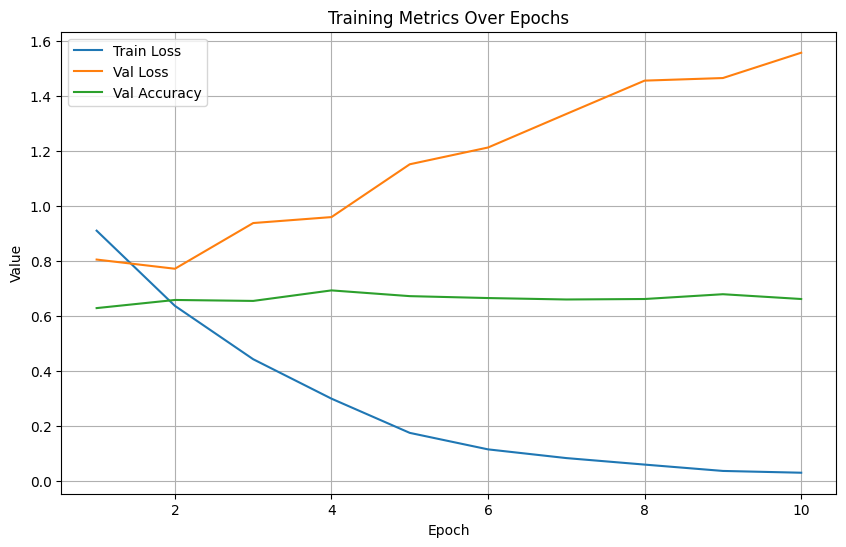

{'train_loss': [0.911032300619852,
  0.6376994978340845,
  0.4437218008060304,
  0.30034515042863197,
  0.1760187614117823,
  0.11604237319192007,
  0.08437306436872671,
  0.06070622117702095,
  0.037639306471978745,
  0.031158779782893522],
 'val_loss': [0.8059898581769731,
  0.7725992235872481,
  0.938737584484948,
  0.9603926108943092,
  1.152358306778802,
  1.213312092754576,
  1.3352462119526334,
  1.4564233587847815,
  1.4658211833900876,
  1.5578486853175693],
 'val_accuracy': [0.6295652173913043,
  0.6591304347826087,
  0.6556521739130434,
  0.6939130434782609,
  0.6730434782608695,
  0.6660869565217391,
  0.6608695652173913,
  0.662608695652174,
  0.68,
  0.662608695652174]}

In [10]:
# Training Time
# 06:35 00:12
# 06:33 00:11
# 06:31 00:11
# 06:35 00:11
# 06:38 00:11

# 06:58 00:11
# 06:54 00:12
# 06:54 00:11
# 06:56 00:11
# 06:58 00:12
import matplotlib.pyplot as plt

# Plot all metrics in the same graph
plt.figure(figsize=(10, 6))
for key, val in best_metric_seq.items():
    plt.plot(range(1, len(val) + 1), val, label=key.replace('_', ' ').title())

plt.title('Training Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
best_metric_seq

In [11]:
# Final Evaluation on Test Set
test_loader = create_data_loader(test, tokenizer, best_params['batch_size'])
print("\nEvaluating final model on test set...")
test_metrics = evaluate_model(best_model, test_loader, device)
print(f"Test set metrics: {test_metrics}")


Evaluating final model on test set...


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:47<00:00,  1.31s/it]

Test set metrics: {'loss': 0.7614871652589904, 'accuracy': 0.6866840731070496, 'precision': 0.6822309689889575, 'recall': 0.6866840731070496, 'f1': 0.683877777743654}


In [12]:
# Set the model to evaluation mode
best_model.eval()

# Example text for prediction
example_text = "harris leads by 1%"

# Tokenize the input text
encoded_input = tokenizer(
    example_text,
    return_tensors="pt", # Return PyTorch tensors
    truncation=True,
    padding=True
)
# Remove token_type_ids if not used
encoded_input.pop("token_type_ids", None)

# Perform prediction without gradient computation
with torch.no_grad():
    outputs = best_model(**encoded_input)

# Get the logits from the model's output
logits = outputs.logits

# Get the predicted class (0, 1, or 2)
predicted_class = torch.argmax(logits, dim=1).item() - 1
print("Predicted class (-1, 0, 1):", predicted_class)

Predicted class (-1, 0, 1): 1
